# Restlebenszeit-Vorhersage / Remaining Useful Lifetime (RUL)

### Beispiel Notebook aus dem ITS.ML Workshop "Inside Out: The Essentials of Predictive Maintenance"

Dieses Beispiel beschreibt exemplarisch das Vorgehen, um eine ML-Pipeline zu erzeugen, das in der Lage ist die Restlebenszeit eines Systems vorherzusagen.

## 1. Daten

In diesem Beispiel nutzen wir die [Turbofan Engine Daten des Nasa Repositories](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) (6. Turbofan Engine Degradation Simulation Data Set). Die darin enthaltenen Datensätze bestehen aus künstlich erzeugten Daten und beschreiben das Verhalten eines Flugzeugtriebwerks, indem unterschiedliche Betriebs- und Fehlerbedingungen erfasst werden.
Ziel ist es ein Modell zu entwickeln, das vorhersagt, wann ein Fehler in der Hochdruckkompressionseinheit (HPC) des Flugzeugtriebwerks auftritt. Die Daten sind in 4 Datensätze unterteilt und entsprechend nummeriert, die jeweils mit unterschiedlichen Umgebungsbedingungen simulieren. Jeder Datensatz ist wiederum aufgeteilt in 3 Dateien (wobei "X" durch die Nummer des Datensatzes ersetzt werden muss):  
* train_FD00X.txt: Trainingsdatensatz bei dem der letzte Timestep als Fehlerzeitpunkt zu interpretieren ist
* test_FD00X.txt: Testdatensatz bei dem jede Instanz zu einem unbestimmten Zeitpunkt endet. Für diesen soll die Restlebenszeit prädiziert werden
* rul_FD00X.txt: Beinhaltet die wahren RUL Werte, die zur Evaluation genutzt werden

Sowohl die Trainingsdaten, als auch die Testdaten, sind im Komma-separierten CSV-Format gespeichert. Im Folgenden sind die Spalten erläutert:
* **Spalte 1: Instanz ID** <br/>
    Alle Instanzen sind nummeriert von 1 - 100, dementsprechend beschreibt die erste Spalte um welche Instanz es sich handelt.
* **Spalte 2: Timestep** <br/> 
    Jede Instanz enthält Aufzeichnungen von Sensoren über einen längeren Zeitraum. Die Zeitpunkte, zu denen es Werte gibt, sind nummeriert und in der zweiten Spalte zu finden.
* **Spalten 3 - 5: Umgebungsbedingungen** <br/>
    Zu den jeweiligen Zeitpunkten wurden Informationen zu den Umgebungsbedigungen gesammelt, welche in diesen Spalten notiert sind.
* **Spalten 6 - 26: Sensor Werte** <br/>
    Insgesamt wurden 21 Sensoren aufgezeichnet, welche in diesen Spalten notiert sind

Sowohl die Umgebungsbedingungen, als auch die Sensor Werte, sind Zeitserien, welche von einem Triebwerk desselben Types stammen.

### 1.1 Daten lesen

Zu Beginn müssen die Daten eingelesen werden. Da der Datensatz in ein Pandas Dataframe geladen wird, ist es möglich die Spalten zu benennen. Dementsprechend wird zuerst die Spaltenbezeichnung erstellt um anschließend die Daten zu laden.

In [1]:
import warnings
warnings.filterwarnings("ignore") # Unterdrücke matplotlib Warnungen für sauberen Output

import pandas as pd

# Erstellen der Spaltennamen für das Dataframe, da der verwendeter Datensatz keine Spaltenbeschreibung besitzt
operational_setting_columns_names=["Operation Setting " + str(i) for i in range(1,4)]
sensor_data_columns_names=["Sensor " + str(i) for i in range(1,22)]
column_names = ["Instance", "Timestep"] + operational_setting_columns_names + sensor_data_columns_names 

# Laden des Trainingdatensatzes FD001 mit den zuvor erstellten Spaltennamen
X_train = pd.read_csv("./CMAPSSData/train_FD001.txt", names=column_names, delim_whitespace=True, dtype=float)
print('Anzahl der Instanzen: ' + str(len(X_train["Instance"].unique())))
X_train.head()

Anzahl der Instanzen: 100


,Instance,Timestep,Operation Setting 1,Operation Setting 2,Operation Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21
0,1.0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,1.0,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,1.0,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,1.0,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,1.0,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


### 1.2 Daten visualisieren

Im Folgenden werden einige Eigenschaften der verschiedenen Sensoren visualisiert. Bei einigen Sensoren ist zu erkennen, dass der minimale Wert dem maximalen Wert gleicht (z.B. Sensor 1, 5, 6, ...). Dies bedeutet, dass in allen Instanzen für diesen Sensor für jeden Timestep der gleiche Wert aufgezeichnet wurde. Dies spricht dafür, dass diese Sensoren keine Aussagekraft haben für eine spätere Prädiktion.
* **mean:** Mittelwert
* **std:** Standardabweichung vom Mittelwert
* **min:** Minimaler Wert
* **50%:** Median
* **max:** Maximaler Wert

In [2]:
X_train.describe(percentiles=[]).transpose()[1:]

,count,mean,std,min,50%,max
Timestep,20631.0,108.807862,6.888099e+01,1.0000,104.0000,362.0000
Operation Setting 1,20631.0,-0.000009,2.187313e-03,-0.0087,0.0000,0.0087
Operation Setting 2,20631.0,0.000002,2.930621e-04,-0.0006,0.0000,0.0006
Operation Setting 3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000
Sensor 1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700
Sensor 2,20631.0,642.680934,5.000533e-01,641.2100,642.6400,644.5300
Sensor 3,20631.0,1590.523119,6.131150e+00,1571.0400,1590.1000,1616.9100
Sensor 4,20631.0,1408.933782,9.000605e+00,1382.2500,1408.0400,1441.4900
Sensor 5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200
Sensor 6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100


Nun werden die Längen der Instanzen betrachtet. Im Folgenden ist ein Diagramm zu sehen, das die Verteilung der Instanzlängen der Trainingsdaten wiedergibt.

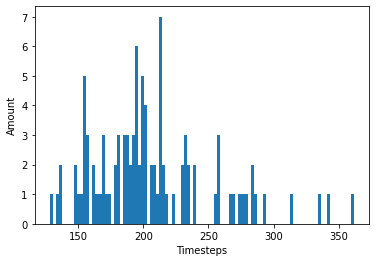

In [3]:
import matplotlib.pyplot as plt 


def plot_label_distribution(data, title=None):
    """
    Erstellt ein Balkendiagramm, das die Lebensdauer der Instanzen visualisiert
    """
    overall_instance_lengths = []
    number_of_instances = len(data["Instance"].unique())
    for instance_id in range(number_of_instances): # Über alle Instanzen
        instance = data[data["Instance"] == instance_id + 1]
        overall_instance_lengths.append(instance.shape[0])

    fig, ax = plt.subplots()
    ax.hist(x=overall_instance_lengths, bins=number_of_instances);
    ax.set(xlabel='Timesteps', ylabel='Amount', title=title)
    fig.show()
    
plot_label_distribution(X_train)

Als nächstes wird eine Instanz näher betrachtet. Je Umgebungsbedingung/Sensor wird der Verlauf der jeweiligen Zeitserie dargestellt. Die X-Achse beschreibt dabei jeweils den zeitlichen Verlauf, wobei die Y-Achse den tatsächlichen Sensor Wert abbildet. Es wird die Instanz dargestellt, dessen ID in der ersten Zeile des folgenden Codes beschrieben ist. 

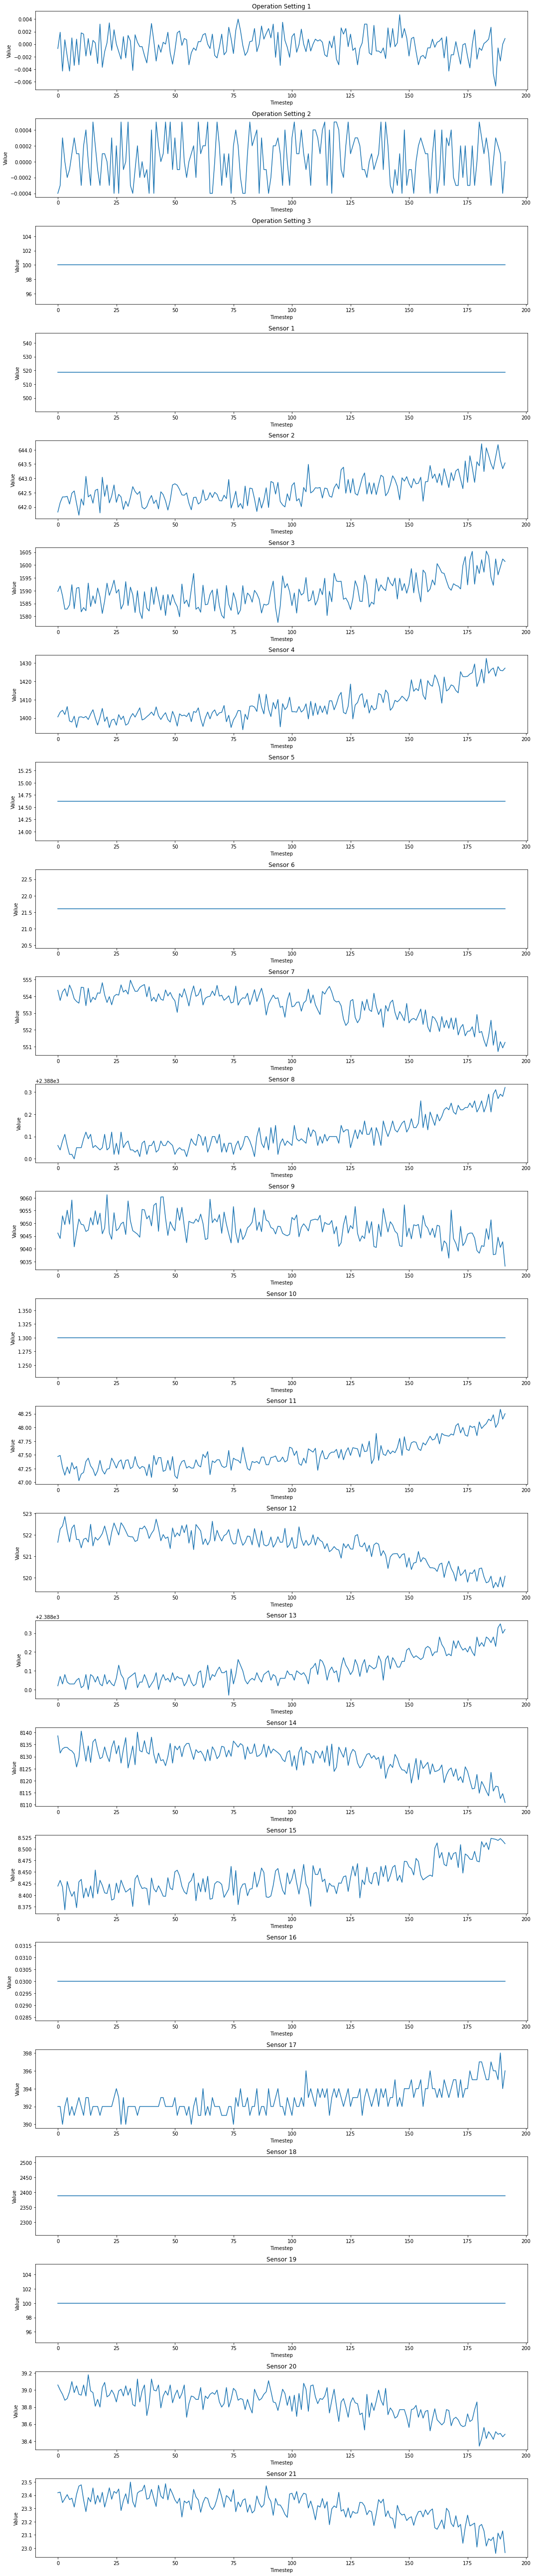

In [4]:
instance_id = 1

# Darstellung des zeitlichen Verlaufs der Umgebungsbedingungen/Sensoren einer Instanz
number_of_plots = len(operational_setting_columns_names) + len(sensor_data_columns_names)
plt.figure(figsize=(15, 3*number_of_plots))
history_dataframe_id = X_train[X_train["Instance"] == instance_id]

for i, v in enumerate(operational_setting_columns_names):
    diagram = plt.subplot(number_of_plots, 1, 1 + i)
    diagram.plot(history_dataframe_id.index.values,history_dataframe_id.iloc[:, 2 + i].values)
    diagram.title.set_text(v)
    diagram.set_xlabel("Timestep")
    diagram.set_ylabel("Value")
    plt.tight_layout()    
    
for i, v in enumerate(sensor_data_columns_names):
    diagram = plt.subplot(number_of_plots, 1, 4 + i)
    diagram.plot(history_dataframe_id.index.values,history_dataframe_id.iloc[:, 5 + i].values)
    diagram.title.set_text(v)
    diagram.set_xlabel("Timestep")
    diagram.set_ylabel("Value")
    plt.tight_layout()
    
plt.show()

# 2. Reduktion auf Regression
Um standard Regressions-Verfahren anwenden zu können, werden gelabelte Instanzen mit einer Feature Representation fester Länge benötigt.

## 2.1 Umwandlung der Run2Failure Daten zu gelabelten Daten
Im Folgenden wird beschrieben, wie die Trainingsdaten des Run2Failure Settings zu RUL-gelabelten Trainingsdaten umgewandelt werden können. Dazu wird jede Instanz an einem zufällig bestimmten Zeitpunkt abgeschnitten, wobei der vordere Teil der Zeitserie behalten wird. Die Länge des abgeschnittenen Teils wird als RUL Label verwendet.


In [5]:
import random

# Der Seed ermöglicht Reproduzierbarkeit der Zufallswerte
random.seed(42)

def decide_new_instance_length(upper_bound):
    """
    Entscheidet per Zufall, wie lang die Instanz zukünftig sein wird. 
    Der Wert liegt in [6, 190] um später mit den Testdaten überein zu stimmen.
    """
    if upper_bound > 190:
        upper_bound = 190
    return random.randint(6, upper_bound)


# Mithilfe von decide_new_instance_length(), wird die Zeitreihe abgeschnitten und das RUL Label erstellt
X_train_labeled= X_train.copy(deep=True)
y_train = []
for instance_id in range(len(X_train["Instance"].unique())):
    instance_length_original = X_train[X_train["Instance"] == instance_id + 1].shape[0]
    instance_length_new = decide_new_instance_length(instance_length_original)
    rul = instance_length_original - instance_length_new
    y_train.append(rul)
    
    to_deleted_lines = X_train_labeled[(X_train_labeled["Instance"] == instance_id + 1) & 
                                       ( X_train_labeled["Timestep"] > instance_length_new)].index
    X_train_labeled.drop(to_deleted_lines,inplace=True)

# Die RUL Label werden nun in ein Pandas DataFrame gespeichert
y_train = pd.DataFrame({"RUL":y_train})
y_train

,RUL
0,23
1,253
2,167
3,113
4,201
...,...
95,228
96,128
97,134
98,125


Als nächstes wird für eine Instanz die originale Länge mit der neuen Länge vergleichen:

In [6]:
instance_id =1
print("Orig: \t" + str(X_train[X_train["Instance"] == instance_id].shape[0]))
print("Neu: \t" + str(X_train_labeled[X_train_labeled["Instance"] == instance_id].shape[0]) + "   RUL: " + str(y_train['RUL'][instance_id-1]))

Orig: 	192
Neu: 	169   RUL: 23


Beim Vergleich der Verteilung der Instanzlängen ist nun ein deutlicher Unterschied in der Länge der Instanzen zu sehen.

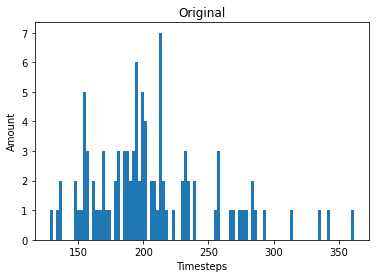

In [7]:
plot_label_distribution(X_train, 'Original')

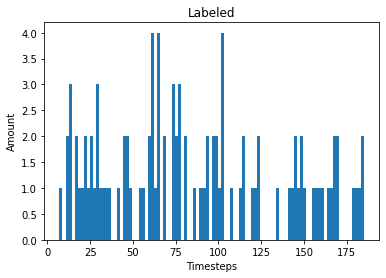

In [8]:
plot_label_distribution(X_train_labeled, 'Labeled')

Im Folgenden werden einige Eigenschaften der verschiedenen Sensoren nach dem labeling Prozess visualisiert.

In [9]:
X_train_labeled.describe(percentiles=[]).transpose()[1:]

,count,mean,std,min,50%,max
Timestep,8634.0,58.854992,4.321323e+01,1.0000,50.00000,185.0000
Operation Setting 1,8634.0,-0.000007,2.163699e-03,-0.0081,-0.00000,0.0072
Operation Setting 2,8634.0,-0.000003,2.947692e-04,-0.0006,-0.00000,0.0006
Operation Setting 3,8634.0,100.000000,0.000000e+00,100.0000,100.00000,100.0000
Sensor 1,8634.0,518.670000,0.000000e+00,518.6700,518.67000,518.6700
Sensor 2,8634.0,642.481754,4.041011e-01,641.2100,642.47500,644.1200
Sensor 3,8634.0,1588.145127,4.949462e+00,1571.0400,1588.10500,1607.2400
Sensor 4,8634.0,1404.854679,6.712481e+00,1382.2500,1404.60000,1434.0400
Sensor 5,8634.0,14.620000,3.552919e-15,14.6200,14.62000,14.6200
Sensor 6,8634.0,21.609690,1.734361e-03,21.6000,21.61000,21.6100


## 2.2 Datenbearbeitung, Extraktion der Merkmale

In diesem Beispiel wird die Bibliothek tsfresh verwendet, um statistische Feature aus den Zeitserien zu extrahieren. Dazu müssen die Daten zuerst in ein 4-spaltiges Format überführt werden. Die zugrundeliegende Idee dieser Darstellung ist, jeden Sensorwert in einer Zeile darzustellen. Ein Sensorwert ist über die folgenden 4 Merkmale eindeutig definiert, die auch die Spalten wiederspiegeln:
1. **instance:** Die ID der Instanz
2. **timestep:** Der Timestep, zu dem der Sensorwert aufgezeichnet wurde
3. **sensor:** Die Umgebungsvariable bzw. der Sensor, der aufgezeichnet wurde
4. **value:** Der Wert des Sensors

In [10]:
''' Erstellen eines neuen Dataframes das den Anforderungen von tsfresh entspricht'''
def change_format(data):
    dataset = list()
    for index, row in data.iterrows():
    #    if index < 5:
        instance_id = pd.to_numeric(row[0])
        timestep = pd.to_numeric(row[1])
        for sensor_id, sensor in enumerate(data.columns[2:]):
            dataset.append([instance_id, timestep, str(sensor_id), pd.to_numeric(row[2 + sensor_id])])
    return pd.DataFrame(dataset, columns=['instance','timestep','sensor','value']).astype({'instance': 'int32','timestep': 'int32', 'sensor': 'str', 'value': 'float32'})

X_train_formated = change_format(X_train_labeled)
X_train_formated

,instance,timestep,sensor,value
0,1,1,0,-0.000700
1,1,1,1,-0.000400
2,1,1,2,100.000000
3,1,1,3,518.669983
4,1,1,4,641.820007
...,...,...,...,...
207211,100,151,19,394.000000
207212,100,151,20,2388.000000
207213,100,151,21,100.000000
207214,100,151,22,38.750000


In [11]:
# laden des Testdatensatzes. Dieser enthält bereits Label, die in einer extra Datei gespeichert wurden.
X_test= pd.read_csv("./CMAPSSData/test_FD001.txt", names=column_names, delim_whitespace=True, dtype=float)
X_test_formated = change_format(X_test)

X_test_formated

,instance,timestep,sensor,value
0,1,1,0,0.002300
1,1,1,1,0.000300
2,1,1,2,100.000000
3,1,1,3,518.669983
4,1,1,4,643.020020
...,...,...,...,...
314299,100,198,19,396.000000
314300,100,198,20,2388.000000
314301,100,198,21,100.000000
314302,100,198,22,38.700001


In [12]:
y_test= pd.read_csv("./CMAPSSData/RUL_FD001.txt", names=["RUL"])
y_test

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


Im Folgenden ist die Anwendung von tsfresh und dessen Ergebnisse zu sehen. 

In [13]:
from tsfresh.transformers import FeatureAugmenter#, RelevantFeatureAugmenter
from tsfresh.feature_extraction import MinimalFCParameters
        
augmenter = FeatureAugmenter(
    column_id="instance",
    column_kind="sensor",
    column_sort="timestep",
    column_value="value",    
    default_fc_parameters=MinimalFCParameters(),
    disable_progressbar=False)

augmenter.set_timeseries_container(X_train_formated)
features = augmenter.transform(pd.DataFrame(index=y_train.index))
features

Feature Extraction: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,...,9__sum_values,9__median,9__mean,9__length,9__standard_deviation,9__variance,9__root_mean_square,9__maximum,9__absolute_maximum,9__minimum
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.0130,0.00000,-0.000077,169.0,0.001892,0.000004,0.001894,0.0047,0.0047,-0.0043,...,93569.859375,553.770020,553.667786,169.0,0.677088,0.458449,553.668213,554.960022,554.960022,551.869995
2,0.0172,0.00055,0.000506,34.0,0.002447,0.000006,0.002499,0.0063,0.0063,-0.0045,...,18855.869141,554.670044,554.584412,34.0,0.420981,0.177225,554.584595,555.250000,555.250000,553.500000
3,-0.0019,-0.00045,-0.000158,12.0,0.001438,0.000002,0.001447,0.0020,0.0029,-0.0029,...,6652.330078,554.385010,554.360840,12.0,0.396867,0.157503,554.360962,554.880005,554.880005,553.450012
4,0.0294,0.00020,0.000387,76.0,0.002131,0.000005,0.002166,0.0059,0.0059,-0.0035,...,42091.468750,553.794983,553.835144,76.0,0.438949,0.192676,553.835327,554.750000,554.750000,552.530029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0016,-0.00020,0.000019,86.0,0.002380,0.000006,0.002380,0.0054,0.0054,-0.0048,...,47688.445312,554.535034,554.516785,86.0,0.391281,0.153101,554.517029,555.640015,555.640015,553.630005
96,-0.0043,-0.00010,-0.000040,108.0,0.002040,0.000004,0.002041,0.0042,0.0045,-0.0045,...,59841.789062,554.130005,554.090637,108.0,0.419306,0.175818,554.090820,555.270020,555.270020,552.969971
97,-0.0276,-0.00005,-0.000373,74.0,0.002146,0.000005,0.002178,0.0043,0.0054,-0.0054,...,41004.929688,554.094971,554.120667,74.0,0.383015,0.146700,554.120789,555.200012,555.200012,553.340027
98,0.0007,0.00010,0.000032,22.0,0.002111,0.000004,0.002111,0.0037,0.0042,-0.0042,...,12195.361328,554.474976,554.334595,22.0,0.624947,0.390559,554.334961,555.450012,555.450012,552.750000


# Regression

Nun wenden wir standard Regression auf die statistischen Features an. Im Folgenden werden zuerst ein paar Methoden definiert, die später die Ergebnisse plotten, gefolgt von der Definition verschiedener Metriken. Anschließend wird eine Methode definiert, die sowohl trainiert, als auch testet und die Ergebnisse visualisiert. Unterhalb der zwei Plots werden auch die Werte der verschiedenen Metriken gelistet. Zum Schluss werden 4 verschiedene Regressoren (jeweils mit default Parametern) trainiert und getestet.

## Ergebnisse plotten

In [14]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(12,7))
    plt.plot(y_test)
    plt.plot(y_pred)    
    plt.title('Prädiktionen der Test-Instanzen (' + model_name + ')')
    plt.xlabel('Instanz-ID')
    plt.ylabel('Instanz-Länge')
    plt.legend(["True Values", "Predicted Values"])
    plt.show()

def plot_percentage_error(y_true, y_pred, model_name):
    plt.figure(figsize=(12,7))
    percentage_error = (y_true - y_pred) / y_true
    plt.stem(np.arange(len(y_test["RUL"])),percentage_error["RUL"])
    plt.title('Prozentualer Fehler der Test-Instanzen (' + model_name + ')')
    plt.xlabel('Instanz-ID')
    plt.ylabel('Prozentualer Fehler')
    plt.text(50, np.amin(percentage_error)-6, 
             'Positive Werte bedeuten, die tatsächliche Laufzeit wurde unterschätzt\nNegative Werte bedeuten, die tatsächliche Laufzeit wurde überschätzt.', 
             horizontalalignment='center')
    plt.show()

## Metriken berechnen

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

def percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sum = 0
    for index in range(0,len(y_true)):
        sum = sum + (y_true[index] - y_pred[index]) / y_true[index]
    return np.mean(sum)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def simple_asymmetric_loss(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sum = 0
    for index in range(0,len(y_true)):
        if y_pred[index]>= y_true[index]:
            sum = sum + y_true[index] - y_pred[index]
    return np.mean(sum)

def complex_asymmetric_loss(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    sum = 0
    for index in range(0,len(y_true)):
        percentage_error = (y_true[index] - y_pred[index]) / y_true[index]
        if percentage_error <= 0 : # late prediction
            ai = math.exp(- (math.log(0.5) + (percentage_error / 5)))
        else: # early prediction
            ai = math.exp(+ (math.log(0.5) + (percentage_error / 20)))
        sum = sum + (1 - ai)
    return np.mean(sum)

Der *InvalidNumberReplacementTransformer* dient dem Zweck die resultierenden Werte von tsfresh auf ihre Kompatiblität  zu scikit-learn sicherzustellen. Dieser wird später einfach in die Pipeline zwischen tsfresh und dem Regressor gehangen.

In [16]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class InvalidNumberReplacementTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        return self

    def transform(self, X):
        extracted_features = np.float32(X.to_numpy())
        features = np.nan_to_num(extracted_features)
        return features

In [17]:
from sklearn.pipeline import make_pipeline

def train_and_test_model(regressor, name):
    pipeline = make_pipeline(
      augmenter,
      InvalidNumberReplacementTransformer(),
      regressor()
     )
    pipeline.set_params(featureaugmenter__timeseries_container=X_train_formated)
    pipeline.fit(pd.DataFrame(index=y_train.index), y_train["RUL"])

    pipeline.set_params(featureaugmenter__timeseries_container=X_test_formated)
    predictions = pipeline.predict(pd.DataFrame(index=y_train.index)) 
    predictions = predictions.reshape(100,1)

    plot_predictions(y_test, predictions, name)
    plot_percentage_error(y_test, predictions, name)
    
    print("MAE: \t%.2f" % mean_absolute_error(y_test, predictions) )
    print("MSE:\t%.2f" % mean_squared_error(y_test, predictions) )
    print("PE:\t%.2f" % percentage_error(y_test, predictions) )
    print("MAPE:\t%.2f" % mean_absolute_percentage_error(y_test, predictions) )
    print("SAL:\t%.2f" % simple_asymmetric_loss(y_test, predictions) )
    print("CAL:\t%.2f" % complex_asymmetric_loss(y_test, predictions) )

## 1. Lineare Regression

Feature Extraction: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


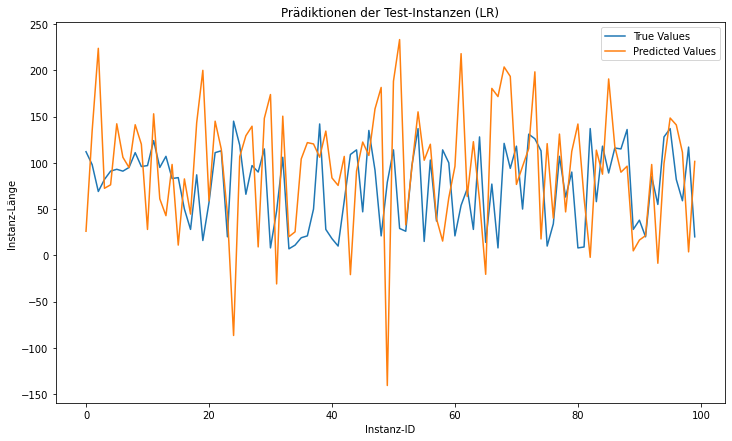

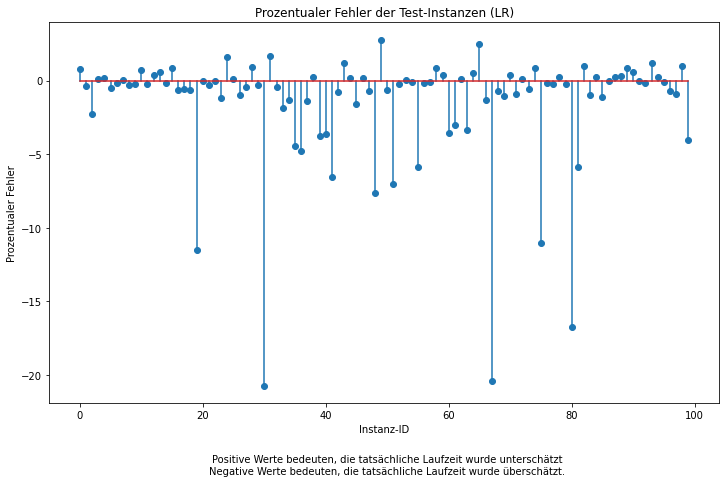

MAE: 	60.59
MSE:	6341.68
PE:	-148.43
MAPE:	196.29
SAL:	-3966.70
CAL:	-436.62


In [18]:
from sklearn.linear_model import LinearRegression

train_and_test_model(LinearRegression, 'LR')

## 2. K-Nearest-Neighbors

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


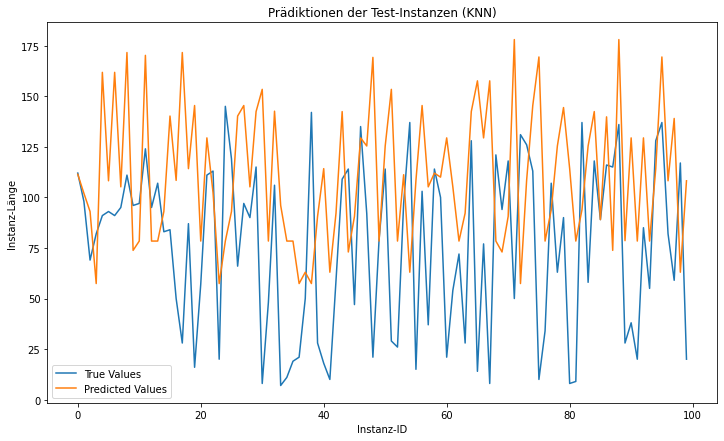

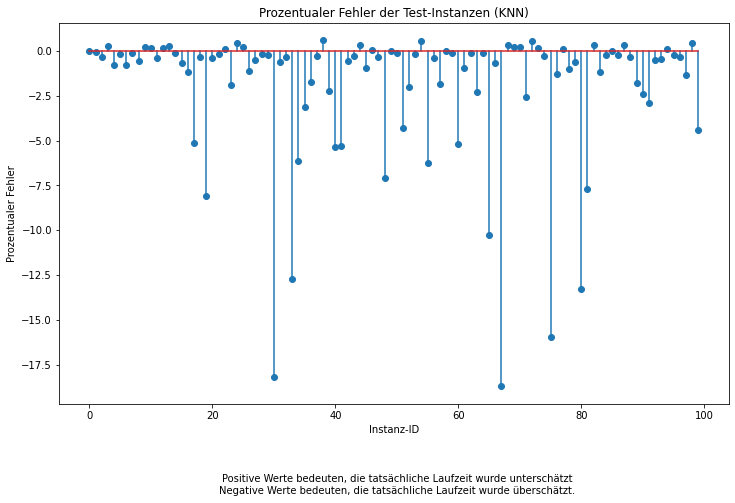

MAE: 	50.36
MSE:	4006.22
PE:	-194.23
MAPE:	206.99
SAL:	-4266.00
CAL:	-402.44


In [19]:
from sklearn.neighbors import KNeighborsRegressor

train_and_test_model(KNeighborsRegressor, 'KNN')

## 3. SVM

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


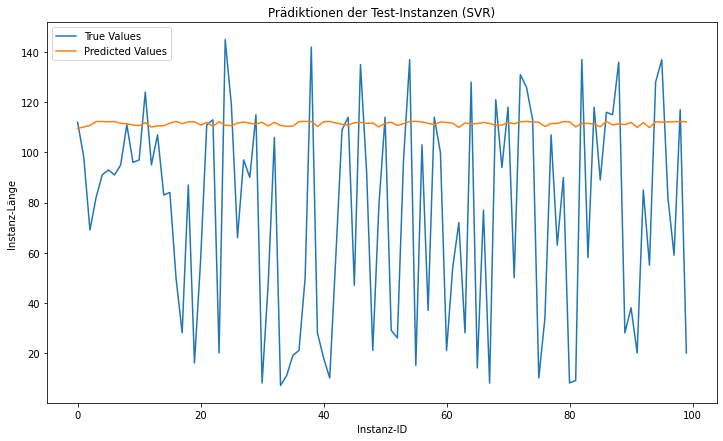

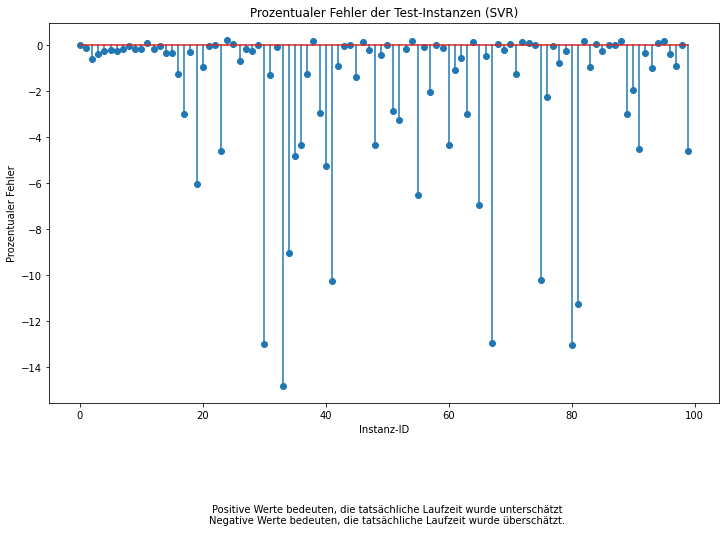

MAE: 	42.47
MSE:	3018.61
PE:	-193.27
MAPE:	198.23
SAL:	-3921.23
CAL:	-288.67


In [20]:
from sklearn.svm import SVR

train_and_test_model(SVR, 'SVR')

## 4. Decision Tree

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


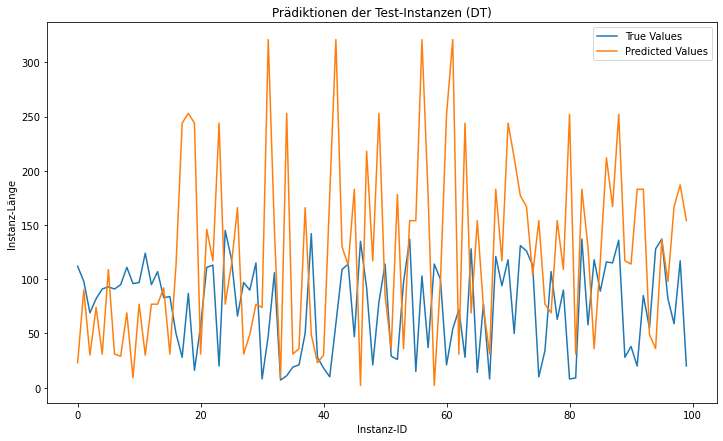

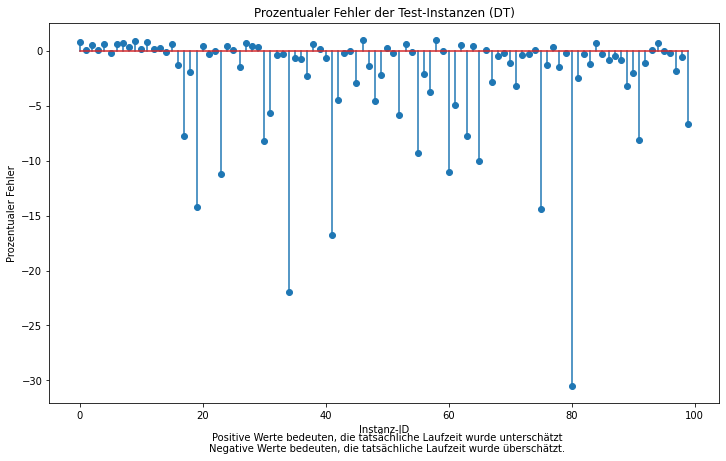

MAE: 	82.44
MSE:	11990.18
PE:	-237.55
MAPE:	269.71
SAL:	-6559.00
CAL:	-1354.99


In [21]:
from sklearn.tree import DecisionTreeRegressor

train_and_test_model(DecisionTreeRegressor, 'DT')